In [1]:
import os
import urllib.request

import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import maui
import maui.utils

Using TensorFlow backend.


In [3]:
print(f'Maui version: {maui.__version__}')

Maui version: 0.1.3


# Maui Vignette

This vignette demonstrates use of maui to integrate multi-omics data from colorectal cancer (CRC) tumors and cell lines. Data is from the TCGA and CCLE, respectively.

#### Dependencies

The vignette uses the python packages `matplotlib` and `seaborn` for visualization. These are not required by the maui package and will need to be installed separately.

### Get the data

First, we'll download gene expression, copy number, and mutation data, as well as metadata.

In [4]:
os.makedirs('data', exist_ok=True)

if not os.path.isfile(os.path.join('data', 'cnv.csv')):
    urllib.request.urlretrieve(
        url='http://bimsbstatic.mdc-berlin.de/akalin/maui-data/coread_for_paper_cnv.csv',
        filename=os.path.join('data', 'cnv.csv')
    )
    
if not os.path.isfile(os.path.join('data', 'gex.csv')):
    urllib.request.urlretrieve(
        url='http://bimsbstatic.mdc-berlin.de/akalin/maui-data/coread_for_paper_gex.csv',
        filename=os.path.join('data', 'gex.csv')
    )

if not os.path.isfile(os.path.join('data', 'mut.csv')):
    urllib.request.urlretrieve(
        url='http://bimsbstatic.mdc-berlin.de/akalin/maui-data/coread_for_paper_mut.csv',
        filename=os.path.join('data', 'mut.csv')
    )

if not os.path.isfile(os.path.join('data', 'subtypes.csv')):
    urllib.request.urlretrieve(
        url='http://bimsbstatic.mdc-berlin.de/akalin/maui-data/coread_for_paper_subtypes.csv',
        filename=os.path.join('data', 'subtypes.csv')
    )

if not os.path.isfile(os.path.join('data', 'survival.csv')):
    urllib.request.urlretrieve(
        url='http://bimsbstatic.mdc-berlin.de/akalin/maui-data/coread_for_paper_survival.csv',
        filename=os.path.join('data', 'survival.csv')
    )

In [5]:
cnv = pd.read_csv(os.path.join('data', 'cnv.csv'), index_col=0)
cnv.head()

,TCGA-DM-A1D0,TCGA-4T-AA8H,TCGA-G4-6322,TCGA-AA-A02E,TCGA-CA-5797,TCGA-G4-6317,TCGA-DM-A28C,TCGA-A6-2679,TCGA-AG-3732,TCGA-A6-2685,...,SNU1033_LARGE_INTESTINE,SNU175_LARGE_INTESTINE,SNU503_LARGE_INTESTINE,SW1116_LARGE_INTESTINE,HCC56_LARGE_INTESTINE,SW403_LARGE_INTESTINE,SW837_LARGE_INTESTINE,NCIH716_LARGE_INTESTINE,HT55_LARGE_INTESTINE,RKO_LARGE_INTESTINE
MACROD2,-0.667,-0.001,0.247,-0.593,0.985,0.986,0.002,1.602,-0.005,0.044,...,0.3457,0.0344,0.1117,-1.3792,-1.4304,-5.4086,-5.7724,-2.8925,-3.7551,-5.9621
HNF4A,0.763,-0.001,0.234,0.535,1.320,1.706,0.002,1.575,-0.005,0.684,...,0.3026,-0.0230,0.1117,0.5808,0.6972,0.7814,0.7099,0.6224,0.4145,0.3929
JPH2,0.763,-0.001,0.234,0.535,1.320,1.706,0.002,1.575,-0.005,0.684,...,0.3026,-0.0230,0.1117,0.5808,0.6972,0.7814,0.7099,0.6224,0.4145,0.3929
R3HDML,0.763,-0.001,0.234,0.535,1.320,1.706,0.002,1.575,-0.005,0.684,...,0.3026,-0.0230,0.1117,0.5808,0.6972,0.7814,0.7099,0.6224,0.4145,0.3929
FITM2,0.763,-0.001,0.234,0.535,1.320,1.706,0.002,1.575,-0.005,0.684,...,0.3026,-0.0230,0.1117,0.5808,0.6972,0.7814,0.7099,0.6224,0.4145,0.3929


In [6]:
gex = pd.read_csv(os.path.join('data', 'gex.csv'), index_col=0)
gex.head()

,TCGA-DM-A1D0,TCGA-4T-AA8H,TCGA-G4-6322,TCGA-AA-A02E,TCGA-CA-5797,TCGA-G4-6317,TCGA-DM-A28C,TCGA-A6-2679,TCGA-AG-3732,TCGA-A6-2685,...,SNU1033_LARGE_INTESTINE,SNU175_LARGE_INTESTINE,SNU503_LARGE_INTESTINE,SW1116_LARGE_INTESTINE,HCC56_LARGE_INTESTINE,SW403_LARGE_INTESTINE,SW837_LARGE_INTESTINE,NCIH716_LARGE_INTESTINE,HT55_LARGE_INTESTINE,RKO_LARGE_INTESTINE
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000202198,4.855891,9.205568,6.527440,0.595815,6.004349,45.198805,5.171670,9.297939,2.890794,15.342999,...,17.83733,88.57648,11.99773,16.09172,22.48761,33.70781,38.01879,31.32460,47.65661,63.93004
ENSG00000211895,0.831433,662.091659,2253.907738,227.896559,259.448507,33.497148,92.531871,26781.944993,2012.832725,1666.767573,...,0.00744,0.00000,0.04958,0.66514,0.00000,0.14382,0.04817,0.00885,0.05872,0.00000
ENSG00000034510,3005.830071,2393.902606,2312.832191,2896.691270,2658.153543,3291.309014,2007.805579,5385.831438,1299.339179,3863.095508,...,1941.87000,1972.74072,1515.57458,1249.52100,2919.46118,1542.28381,995.87891,1521.44495,2358.62549,1713.55505
ENSG00000087086,13913.949581,1139.065773,1780.765946,2380.278895,3286.305387,2322.741438,2210.857310,1576.866087,1134.467501,3661.551885,...,742.40918,320.07034,5460.72314,597.27704,983.68756,947.93945,1522.77112,1522.03857,2818.78662,4131.83838
ENSG00000102837,46.555391,73.775732,499.938588,339.271345,146.964388,38.123727,3593.373932,190.109445,121.231444,108.279930,...,1.34823,0.05802,0.06332,0.03641,3936.25464,6.57603,0.00000,0.01018,0.97715,0.00914


In [7]:
mut = pd.read_csv(os.path.join('data', 'mut.csv'), index_col=0)
mut.head()

,TCGA-DM-A1D0,TCGA-4T-AA8H,TCGA-G4-6322,TCGA-AA-A02E,TCGA-CA-5797,TCGA-G4-6317,TCGA-DM-A28C,TCGA-A6-2679,TCGA-AG-3732,TCGA-A6-2685,...,SNU1033_LARGE_INTESTINE,SNU175_LARGE_INTESTINE,SNU503_LARGE_INTESTINE,SW1116_LARGE_INTESTINE,HCC56_LARGE_INTESTINE,SW403_LARGE_INTESTINE,SW837_LARGE_INTESTINE,NCIH716_LARGE_INTESTINE,HT55_LARGE_INTESTINE,RKO_LARGE_INTESTINE
TTN,0,0,1,1,0,1,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
TP53,1,0,0,1,1,1,0,0,0,1,...,1,0,1,1,1,1,1,1,1,0
KRAS,1,1,0,1,0,0,0,0,0,1,...,1,1,0,1,1,1,1,1,0,0
APC,1,1,1,0,1,1,1,0,0,0,...,1,1,1,1,0,1,1,0,1,0
SYNE1,0,0,0,1,0,0,1,0,1,0,...,1,1,0,0,0,0,1,1,1,1


In [8]:
survival = pd.read_csv(os.path.join('data', 'survival.csv'), index_col=0)
survival.head()

,duration,observed,gender,age,stage
bcr_patient_barcode,,,,,
TCGA-3L-AA1B,154,False,0,61.312329,1.0
TCGA-4N-A93T,8,False,1,67.186301,3.0
TCGA-4T-AA8H,160,False,0,42.449315,2.0
TCGA-5M-AAT4,49,True,1,74.232877,4.0
TCGA-5M-AAT6,290,True,0,40.690411,4.0


In [9]:
subtypes = pd.read_csv(os.path.join('data', 'subtypes.csv'), index_col=0)
subtypes.head()

,dataset,age,gender,stage,pt,pn,pm,tnm,grade,msi,cimp,kras_mut,braf_mut,cms_label,osMo,osStat,rfsMo,rfsStat
sample,,,,,,,,,,,,,,,,,,
TCGA-A6-2670,tcga,45.0,male,2.0,3.0,0.0,0.0,IIA,NaN,NaN,CIMP.Neg,0.0,0.0,CMS4,13.906849,0.0,NaN,NaN
TCGA-A6-2671,tcga,85.0,male,4.0,3.0,2.0,1.0,IV,NaN,mss,CIMP.Neg,0.0,0.0,CMS4,21.304110,0.0,NaN,NaN
TCGA-A6-2672,tcga,82.0,female,3.0,3.0,1.0,0.0,IIIB,NaN,msi,CIMP.High,0.0,0.0,CMS1,16.536986,0.0,NaN,NaN
TCGA-A6-2674,tcga,71.0,male,4.0,3.0,2.0,1.0,IV,NaN,mss,CIMP.Neg,0.0,0.0,CMS4,17.194521,0.0,NaN,NaN
TCGA-A6-2675,tcga,78.0,male,2.0,3.0,0.0,NaN,IIA,NaN,mss,CIMP.Neg,0.0,0.0,CMS4,16.931507,0.0,NaN,NaN


### Scale gene expression data of TCGA and CCLE separately and together

The gene expression data (FPKM / RPKM) from CCLE and TCGA need to each be scaled separately before being jointly normalized, in order to map them to the same space.

In [10]:
gex_tcga = maui.utils.scale(gex.loc[:,gex.columns.str.contains('TCGA')])
gex_ccle = maui.utils.scale(gex.loc[:,~gex.columns.str.contains('TCGA')])

gex = pd.concat([gex_tcga, gex_ccle], axis=1)
gex = maui.utils.scale(gex)
gex.head()

,TCGA-DM-A1D0,TCGA-4T-AA8H,TCGA-G4-6322,TCGA-AA-A02E,TCGA-CA-5797,TCGA-G4-6317,TCGA-DM-A28C,TCGA-A6-2679,TCGA-AG-3732,TCGA-A6-2685,...,SNU1033_LARGE_INTESTINE,SNU175_LARGE_INTESTINE,SNU503_LARGE_INTESTINE,SW1116_LARGE_INTESTINE,HCC56_LARGE_INTESTINE,SW403_LARGE_INTESTINE,SW837_LARGE_INTESTINE,NCIH716_LARGE_INTESTINE,HT55_LARGE_INTESTINE,RKO_LARGE_INTESTINE
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000202198,-0.089120,-0.088563,-0.088906,-0.089667,-0.088973,-0.083947,-0.089080,-0.088551,-0.089372,-0.087775,...,-0.533138,2.542210,-0.787012,-0.609028,-0.330970,0.156823,0.344240,0.053214,0.763240,1.470719
ENSG00000211895,-0.523424,-0.202332,0.570615,-0.413167,-0.397846,-0.507563,-0.478897,12.480840,0.453555,0.285514,...,-0.491682,-0.512073,-0.376185,1.310930,-0.512073,-0.117894,-0.380050,-0.487817,-0.351135,-0.512073
ENSG00000034510,-0.033693,-0.404153,-0.453233,-0.099766,-0.244176,0.139135,-0.637896,1.407156,-1.066801,0.485294,...,-0.258449,-0.229124,-0.663397,-0.916127,0.670186,-0.638025,-1.157067,-0.657820,0.137436,-0.475331
ENSG00000087086,8.178617,-1.318908,-0.841834,-0.396125,0.277463,-0.438901,-0.522082,-0.993424,-1.322327,0.556441,...,-0.653667,-1.081281,4.123571,-0.800612,-0.409376,-0.445570,0.136440,0.135698,1.448641,2.778090
ENSG00000102837,-0.511785,-0.490640,-0.159594,-0.284401,-0.433786,-0.518334,2.243403,-0.400271,-0.453776,-0.463837,...,-0.158675,-0.161104,-0.161094,-0.161145,7.250145,-0.148832,-0.161213,-0.161194,-0.159373,-0.161196


-----------------------------------

## Fit maui model

With normalized data, we are ready to fit a maui model.

### Setting up tensorflow to only use 1 CPU cure

In [11]:
from keras import backend as K
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))

### Fitting the maui model and infering latent factors in multi-omics data

The `Maui` model implements `sklearn`'s `BaseEstimator` interface. So first we instantiate a model, with the parameters we desire, and then we may fit it using either `fit()` or, to get latent factors out directly, using `fit_transform()`.

We'll instantiate a stacked autoencoder with one hidden layer with 1100 nodes, and a latent layer with 70 nodes, which we'll train over 400 epochs.

In [12]:
maui_model = maui.Maui(n_hidden=[1100], n_latent=70, epochs=400)
%time z = maui_model.fit_transform({'mRNA': gex, 'Mutations': mut, 'CNV': cnv})

CPU times: user 8min 17s, sys: 52.1 s, total: 9min 10s
Wall time: 9min 12s


### Checking model convergence 

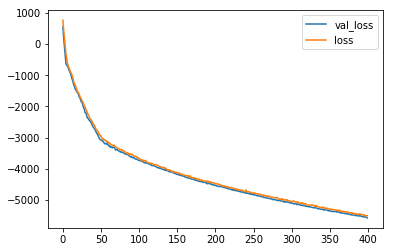

In [13]:
maui_model.hist.plot()

----------------------------

## Latent factor representation

We now have a set of latent factors, `z`, which describe the variation in the data, across the different omics types.

Let's first see if these latent factors reproduce the known sub-types from the literature. The CRC tumors in the TCGA data have an associated "Consensus Molecular Subtype" (CMS) --- but some samples do not belong to a CMS subtype. Let's first focus on the ones that do.

In [14]:
y = subtypes.cms_label
y_cmsonly = y[y!='NOLBL']
y_cmsonly = y_cmsonly.loc[list(set(y_cmsonly.index) & set(gex.columns))]

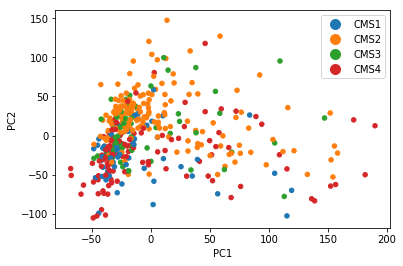

In [15]:
cmap = dict(zip(sorted(y_cmsonly.unique()), sns.color_palette()))
ycols = [cmap[l] for l in y_cmsonly]

legend_handles = [mlines.Line2D([], [], color=cmap[label], label=label, marker='o',
                                markersize=10, linewidth=0) for label in cmap]

pcs = pd.DataFrame(PCA(2).fit_transform(z), columns=['PC1', 'PC2'], index=z.index).loc[y_cmsonly.index]
pcs.plot.scatter(x='PC1', y='PC2', c=ycols)
plt.legend(handles=legend_handles)

It appears from the PCA that the tumors cluster somewhat by their CMS label. We can use SVMs to see just how predictive the latent factors are of the CMS labels:

/home/jona/miniconda3/envs/maui/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, 'TPR')

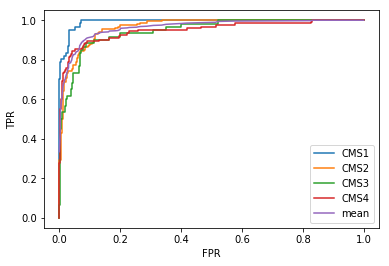

In [16]:
rocs = maui_model.compute_roc(y_cmsonly)

fig, ax = plt.subplots()
for k in rocs:
    rocs[k].plot('FPR','TPR', ax=ax, label=k)
plt.ylabel("TPR")

## Clustering

While we think the CMS clusters are generally true, they are based on gene expression data only. We would like to use maui to find new clusters in the data, but with the starting point of the CMS.

To that end, we can use k-means clustering, and pick the K that reaches a result that's the closest to the CMS, where by closest we mean has the most mutual information

In [17]:
yhat = maui_model.cluster(ami_y = y_cmsonly)

/home/jona/miniconda3/envs/maui/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/jona/miniconda3/envs/maui/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


This gives us the clusters (`yhat`) which are closest to the CMS, but we can also look at the adjusted mutual information (AMI) given by other values of K:

Text(0, 0.5, 'AMI')

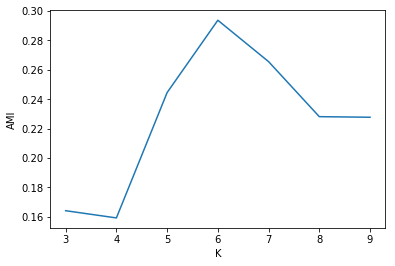

In [18]:
maui_model.kmeans_scores.plot()
plt.ylabel("AMI")

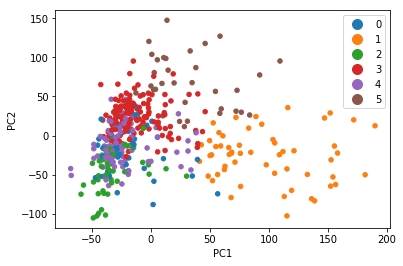

In [19]:
cmap_clusters = dict(zip(sorted(yhat.unique()), sns.color_palette()))
ycols_clusters = [cmap_clusters[l] for l in yhat]

legend_handles = [mlines.Line2D([], [], color=cmap_clusters[label], label=label, marker='o',
                                markersize=10, linewidth=0) for label in cmap_clusters]

pcs = pd.DataFrame(PCA(2).fit_transform(z), columns=['PC1', 'PC2'], index=z.index).loc[y_cmsonly.index]
pcs.plot.scatter(x='PC1', y='PC2', c=ycols_clusters)
plt.legend(handles=legend_handles)

### We can see how predictive these clusters are of patient survival

Text(0.1, 0.1, 'log-rank p=0.433')

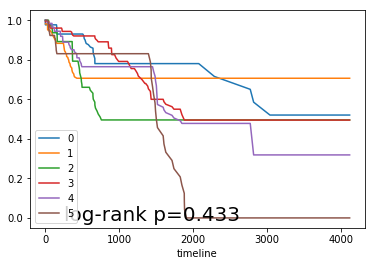

In [20]:
surv_fns = maui.utils.estimate_kaplan_meier(yhat, survival)
surv_fns.plot()
test_stat, p_value = maui.utils.multivariate_logrank_test(yhat, survival)
ax = plt.gca()
ax.text(0.1, .1, f'log-rank p={p_value:.3f}', transform=ax.transAxes, va='top', fontsize=20)

Note that the CMS labels are *not* predictive of survival in the TCGA data.

Text(0.1, 0.1, 'log-rank p=0.819')

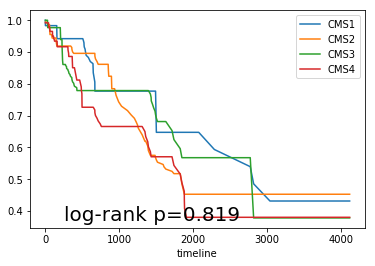

In [21]:
surv_fns = maui.utils.estimate_kaplan_meier(y_cmsonly, survival)
surv_fns.plot()
test_stat, p_value = maui.utils.multivariate_logrank_test(y_cmsonly, survival)
ax = plt.gca()
ax.text(0.1, .1, f'log-rank p={p_value:.3f}', transform=ax.transAxes, va='top', fontsize=20)

### Selecting latent factors which are most relevant for patient survival

We have inferred many latent factors, most of which might not be predictive of survival on their own. We can filter them down to the ones that are, on their own, using Cox Proportional Hazards (CPH) regressions, while controlling for the covariates in `survival` (age, sex, tumor stage), and only picking the ones which have a statistically significant nonzero coefficient in the CPH regression.

In [22]:
z_clinical = maui_model.select_clinical_factors(survival)
z_clinical.head()

,LF6,LF22,LF34,LF44,LF56,LF60,LF68
TCGA-DM-A1D0,0.000000,0.000000,51.091930,0.000000,0.000000,4.945371,0.000000
TCGA-4T-AA8H,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA-G4-6322,0.000000,0.000000,0.000000,0.000000,5.696293,0.000000,9.208014
TCGA-AA-A02E,0.000000,11.310296,0.000000,2.227932,0.000000,51.975220,0.000000
TCGA-CA-5797,47.578671,0.000000,30.425629,0.000000,7.586510,5.982908,0.000000


We might now focus on these latent factors for down-stream analysis, if patient stratification by survival groups is our main interest.

-----------

## Filtering and merging latent factors

We recommend running maui with more latent factors than you think you need. This way you are sure to learn useful ones, and the bad ones can be filtered away.

One way to do this is demonstrated above, using `select_clinical_factors` to trim the list of latent factors to those which are shows to predict patient survival. However, if we're dealing with non-patient data, or we don't have ground truth labels, we may want to drop latent factors based on statistical measures.

Maui provides two ways of doing this:

- Dropping latent factors which are unexplanatory (don't predict the input feature well in a linear model)
- Merging latent factors which are similar

A heatmap shows that there is some co-linearity in the latent factor space:

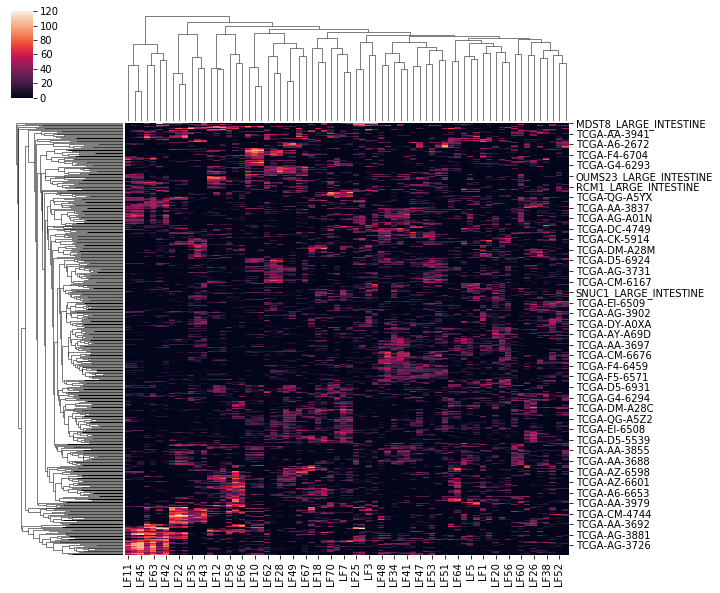

In [23]:
sns.clustermap(maui_model.z_)

Using built-in functionality, we can reduce it by merging latent factors:

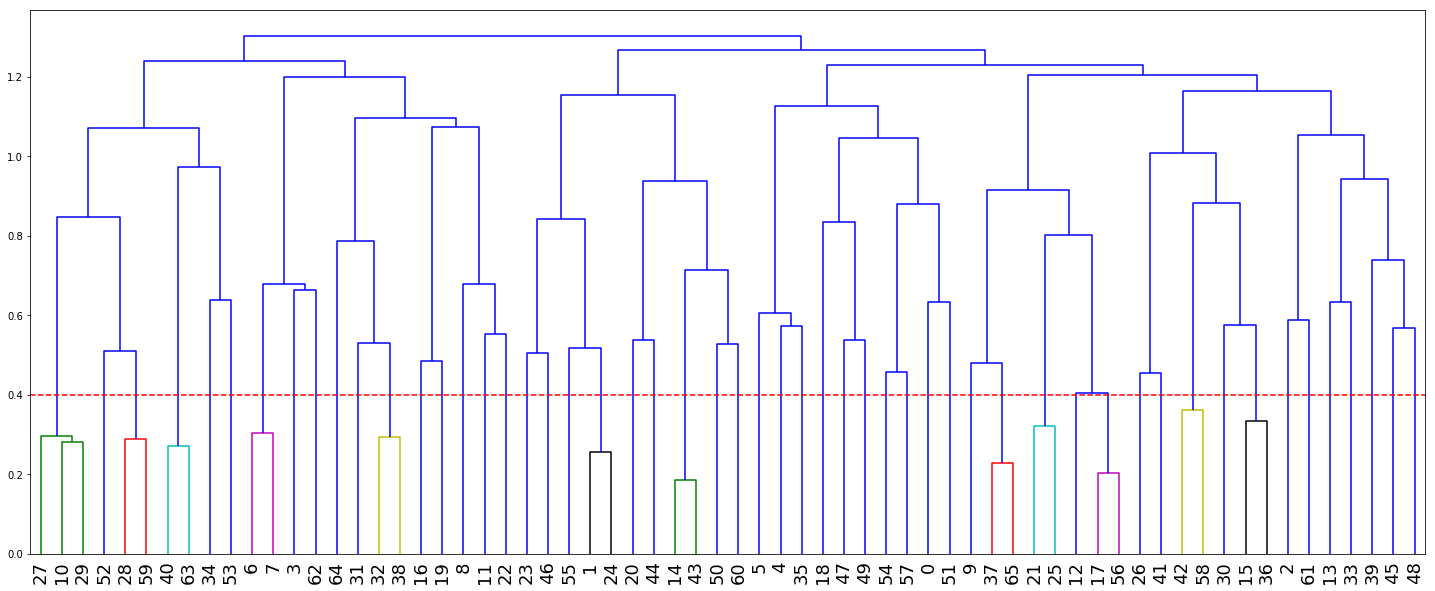

In [25]:
z_merged = maui_model.merge_similar_latent_factors(distance_threshold=.4)

The dendrogram shows ewhich latent factors have been merged, and the threshold level.

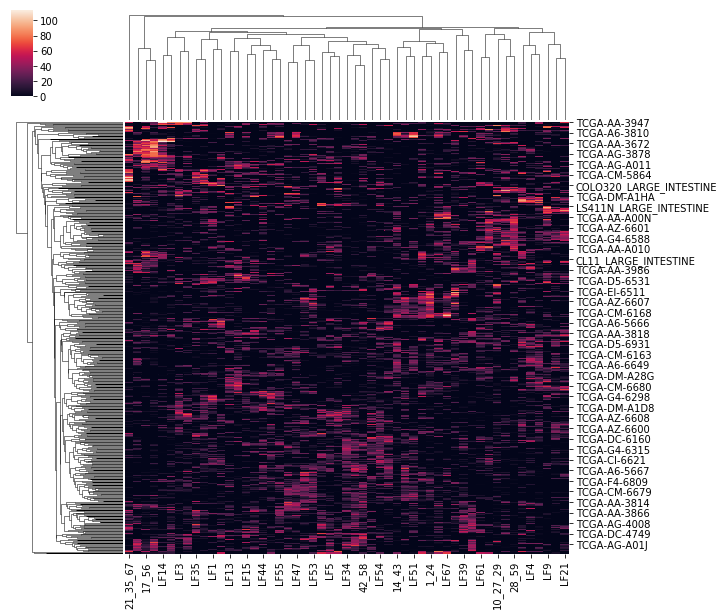

In [26]:
sns.clustermap(z_merged)

In [27]:
z_merged.shape

(573, 53)

Even after merging, some latent factors might poorly explain the variance in the input features. We can drop those also

In [28]:
z_filtered = maui_model.drop_unexplanatory_factors()
z_filtered.shape

(573, 41)

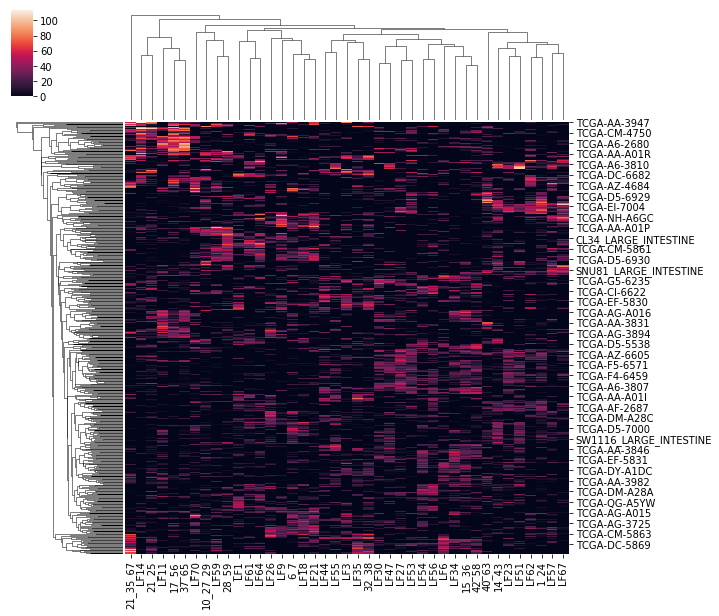

In [29]:
sns.clustermap(z_filtered)

We can 

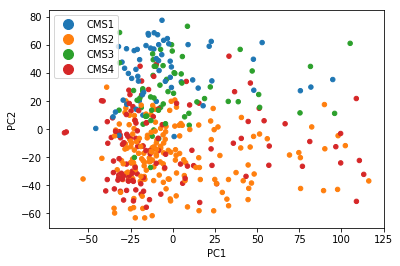

In [30]:
cmap = dict(zip(sorted(y_cmsonly.unique()), sns.color_palette()))
ycols = [cmap[l] for l in y_cmsonly]

legend_handles = [mlines.Line2D([], [], color=cmap[label], label=label, marker='o',
                                markersize=10, linewidth=0) for label in cmap]

pcs = pd.DataFrame(PCA(2).fit_transform(z_filtered), columns=['PC1', 'PC2'], index=z.index).loc[y_cmsonly.index]
pcs.plot.scatter(x='PC1', y='PC2', c=ycols)
plt.legend(handles=legend_handles)

Text(0, 0.5, 'TPR')

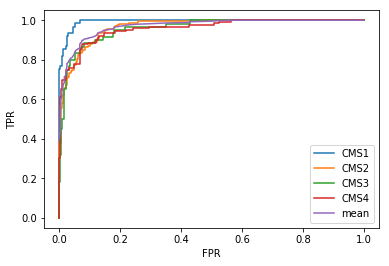

In [31]:
rocs = maui_model.compute_roc(y_cmsonly)

fig, ax = plt.subplots()
for k in rocs:
    rocs[k].plot('FPR','TPR', ax=ax, label=k)
plt.ylabel("TPR")

----------------------------

## The system this was run on.

In [33]:
import IPython
print(IPython.sys_info())

{'commit_hash': '59a7834d2',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/home/jona/miniconda3/envs/maui/lib/python3.6/site-packages/IPython',
 'ipython_version': '7.1.1',
 'os_name': 'posix',
 'platform': 'Linux-4.15.0-38-generic-x86_64-with-debian-stretch-sid',
 'sys_executable': '/home/jona/miniconda3/envs/maui/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.6.6 | packaged by conda-forge | (default, Oct 12 2018, '
                '14:08:43) \n'
                '[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]'}


In [34]:
!pip freeze

absl-py==0.6.1
alabaster==0.7.12
astor==0.7.1
atomicwrites==1.2.1
attrs==18.2.0
Babel==2.6.0
backcall==0.1.0
bleach==3.0.2
certifi==2018.10.15
chardet==3.0.4
coverage==4.5.2
cycler==0.10.0
decorator==4.3.0
defusedxml==0.5.0
docutils==0.14
entrypoints==0.2.3
gast==0.2.0
grpcio==1.16.0
h5py==2.8.0
idna==2.7
imagesize==1.1.0
ipykernel==5.1.0
ipython==7.1.1
ipython-genutils==0.2.0
ipywidgets==7.4.2
jedi==0.13.1
Jinja2==2.10
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==6.0.0
jupyter-core==4.4.0
jupyterlab==0.35.4
jupyterlab-server==0.2.0
Keras==2.2.4
Keras-Applications==1.0.6
Keras-Preprocessing==1.0.5
kiwisolver==1.0.1
lifelines==0.14.6
Markdown==3.0.1
MarkupSafe==1.1.0
matplotlib==3.0.2
-e git+git@github.com:BIMSBbioinfo/maui.git@c75cc96e3cd629168add745262b5c9833844da48#egg=maui
maui-tools==0.1
mistune==0.8.4
more-itertools==4.3.0
nbconvert==5.4.0
nbformat==4.4.0
notebook==5.7.0
numpy==1.15.4
packaging==18.0
pandas==0.23.4
pandocfilters==1.4.2
parso==0.3.1
pexpe